#Strike Team Alpha Data Cleaning 

In [1]:
import numpy as np
import pandas as pd
import os, re
from matplotlib import pyplot as plt

In [10]:
#Master Variable Names
dirty_data_path = "C:\\Users\\brown\\ACME\\byu_vol3_sem2\\Data\\orgi_data.zip" #Folder path to entire dataset
cleaned_folder_path = 'data/' #Folder path to cleaned dataset

# 1. 
Describe test-train split for your data and why it is useful in this scenario.

Summary of Data: Our data consists of midi data for songs of classical music. We have multiple songs from composers such as Bach, Beethoven, Busoni, Chopin, Handel, Schubert, and Vivaldi to name a few. Each song contains 15 columns of features which the midi player uses to produce music. A given song may contain thousands of timepoints. 

As described in our project proposal, we have two goals for this project. Our adequate goal is to be able to classify a particular song as written by a particular composer. In this scenario, we would shuffle all of our songs and select a certain percentage (5-15%) of those songs to be the testing set. We would train on the songs available to us in the training set, and calculate the accuracy of a classifier on the test songs.

Our ambitious goal is to be able to forecast the notes of a particular song. In this scenario, we would select a particular song, and train on a certain percentage of the time points for that song. For example, we may train on the first 2 minutes of a song. We would than forecast starting at the point where we left off training, say at 2 minutes. Our test set would be the ground truth of that song after two minutes.

# 2. 
Print out a few dozen rows of the data. Is there anything you didn't expect to see? What opportunities for data cleaning and feature engineering may be important? Take care of these things.

In [12]:
#Example of original song data
samp_file = 'C:\\Users\\brown\\ACME\\byu_vol3_sem2\\Data\\orig_data\\midi\\Bach\\01 Menuet.csv'
df = pd.read_csv(samp_file)
print("The top of the data")
print(df.head(5))

The top of the data
   tick            type  time  meta  track  numerator  denominator  \
0     0      track_name     0     1      0        NaN          NaN   
1     0  control_change     0     0      1        NaN          NaN   
2     0  control_change     0     0      1        NaN          NaN   
3     0  program_change     0     0      1        NaN          NaN   
4     0         note_on     0     0      1        NaN          NaN   

   clocks_per_click  notated_32nd_notes_per_beat  key  tempo  control  value  \
0               NaN                          NaN  NaN    NaN      NaN    NaN   
1               NaN                          NaN  NaN    NaN      7.0  110.0   
2               NaN                          NaN  NaN    NaN     10.0   35.0   
3               NaN                          NaN  NaN    NaN      NaN    NaN   
4               NaN                          NaN  NaN    NaN      NaN    NaN   

   channel  program  note  velocity  
0      NaN      NaN   NaN       NaN  
1 

In [13]:
print("Data points 10-20")
print(df[10:20])

Data points 10-20
    tick            type  time  meta  track  numerator  denominator  \
10     0  control_change     0     0      1        NaN          NaN   
11     0         note_on     0     0      2        NaN          NaN   
12     0  control_change     0     0      3        NaN          NaN   
13     0  control_change     0     0      3        NaN          NaN   
14     0  control_change     0     0      3        NaN          NaN   
15     0  program_change     0     0      3        NaN          NaN   
16     0  control_change     0     0      4        NaN          NaN   
17     0  control_change     0     0      4        NaN          NaN   
18     0  control_change     0     0      4        NaN          NaN   
19     0  control_change     0     0      4        NaN          NaN   

    clocks_per_click  notated_32nd_notes_per_beat  key  tempo  control  value  \
10               NaN                          NaN  NaN    NaN     32.0    0.0   
11               NaN                  

## Data Cleaning

In [ ]:
def get_durations(song):
    note_start_index = set()
    durations = np.empty((len(song),1))
    notes = np.empty((sum(song[:,4] != 0)))
    for j, note_data in enumerate(song):
        if note_data[4] != 0: # If this note is turning on
            note_start_index.add(j) 
            occurances = np.where((song[j:,2] == note_data[2]) & (song[j:,4] == 0))
            occurances = occurances[0]
            if np.allclose(occurances, [0]):
                durations[j] = 0. # Set the duration to zero for singular notes
            else:
                off_ind = occurances[0]
                durations[j] = song[j+off_ind,0] - note_data[0]
    return np.concatenate((song,durations),axis=1)

In [ ]:
# Load a list of composers
composers = []
f = open("data/composers.txt", "r")
file_string = f.read()
composers = file_string.split(', ')

In [ ]:
# Get a list of all csv files
directory = "data/csv";

csv_list = [];

for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.csv'):
            csv_list.append(os.path.join(root,file));

# Filter the csv_list by composer
songs_by_composer_dict = {}
for composer in composers:
    sublist = []
    for filename in csv_list:
        if composer in filename:
            sublist.append(filename)
    songs_by_composer_dict[composer] = sublist

In [ ]:
song_index_by_composer = {}
# For each composer
for composer in composers:
    # Keep track of where we are
    print(composer, str(composers.index(composer)) + "/" + str(len(composers)))
    
    # Initialize
    all_songs_by_composer = []
    
    # Get the list of songs
    song_list = songs_by_composer_dict[composer]
    
    # Store the indecies of each song
    song_index_by_composer[composer] = {i:song_list[i] for i in range(len(song_list))}

    if not song_list: # Skip empty lists 
        continue
    else:
        for song_directory in song_list:
            # Read csv as df
            time_srs = []
            df = pd.read_csv(song_directory)
            
            # Standardize "note_off" notation
            if "note_off" in np.unique(df.type):
                df.loc[df.type=="note_off","velocity"] = 0
                df.loc[df.type=="note_off","type"] = "note_on"
            
            # Filter to just note controls
            note_df = df[df.type=="note_on"]
            note_df.sort_values("tick")
            unique_ticks = note_df.tick.unique()
            for t in unique_ticks:
                for note in note_df.note[note_df.tick == t]:
                    note_data = note_df[(note_df.tick == t) & (note_df.note == note)]
                    channel = note_data.channel.values[0]
                    velocity = note_data.velocity.values[0]
                    time = note_data.time.values[0]
                    if np.isnan(note): # Clean NaNs
                        continue
                    else:
                        time_srs.append((t,time,note,channel,velocity))
                        
            # Convert to np array and calculate the durations (feature engineering)
            arr = np.array(time_srs) 
            all_songs_by_composer.append(get_durations(arr))
        
        # Save the data
        np.save("npData/" + composer,np.array(all_songs_by_composer,dtype=object))
        np.save("npData/index/" + composer + " song index", song_index_by_composer[composer])
                        

Based on What we have reserached about midi data, our files are pretty standard. However, one thing that we didn't expect to see was that the tempos in some of the files were changing drastically in a short period of time in the song. We are calling this noise in the data since the tempos normally shouldn't change that drastically in a piece. The good thing though is that we don't need to consider the tempos to train because we are more interested in the duration of the notes in relation to the time signature and not the tempo in real time. 

The feature engineering necessary in our MIDI data has to do with the durations of the notes. The notes are measured in ticks from when they turn on until they turn off. So the data doesn't explicitly give note durations. Instead it we had to write a function to extract the note durations and save those separately. Additionally, the beginning of the MIDI files has to do with instrumentation and setup so for now we've excluded them, but if we try to accomplish our ambitious goal then we'll have to find a way to generate that.

# 3. 
Plot a few individual time series and do a similar check. Is there anything unbelievable you see?

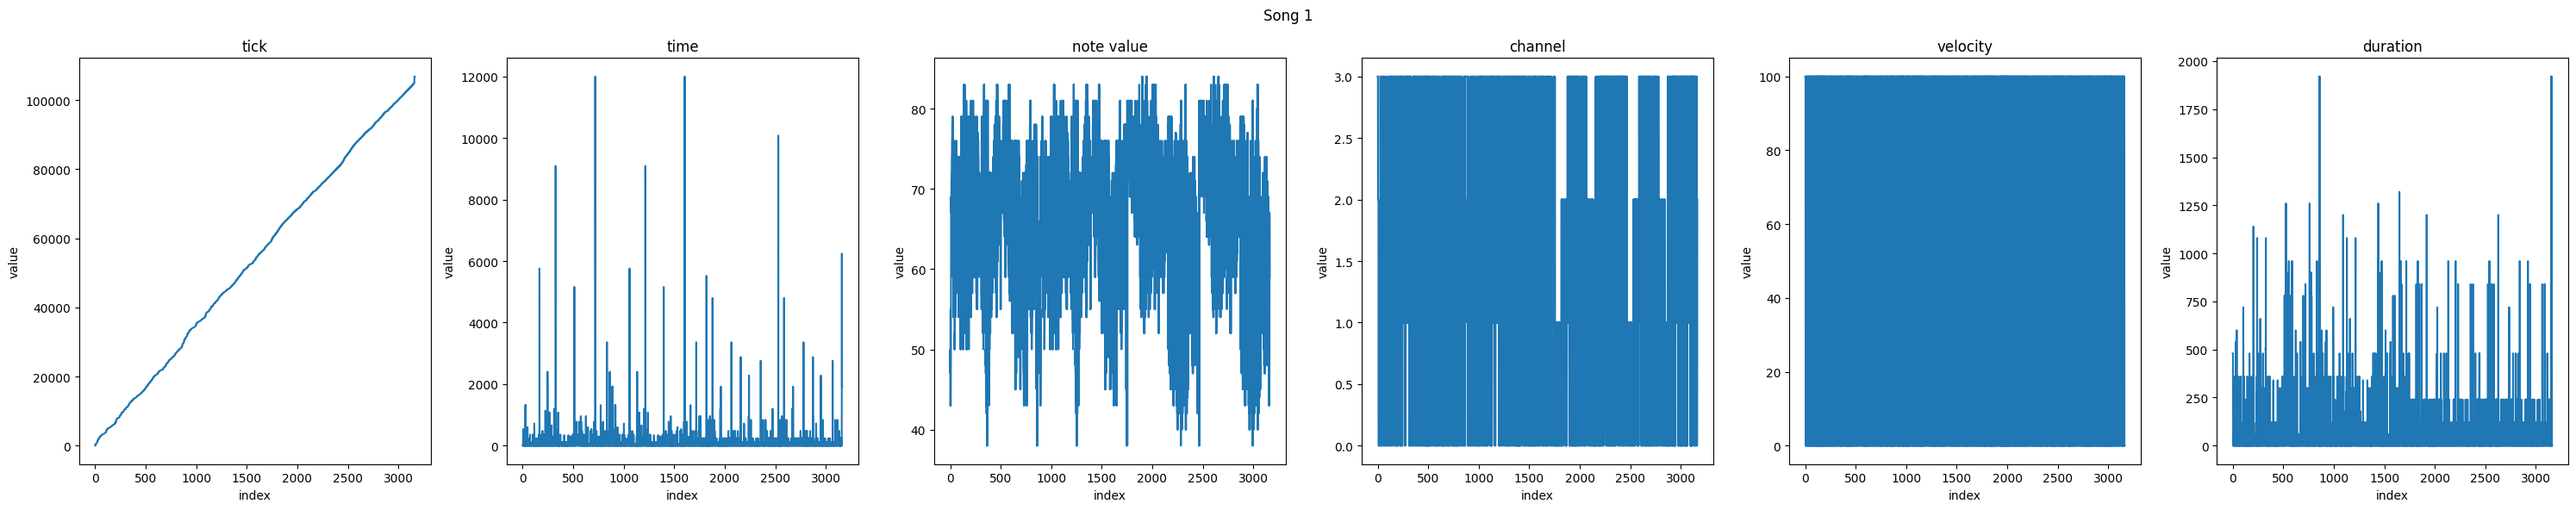

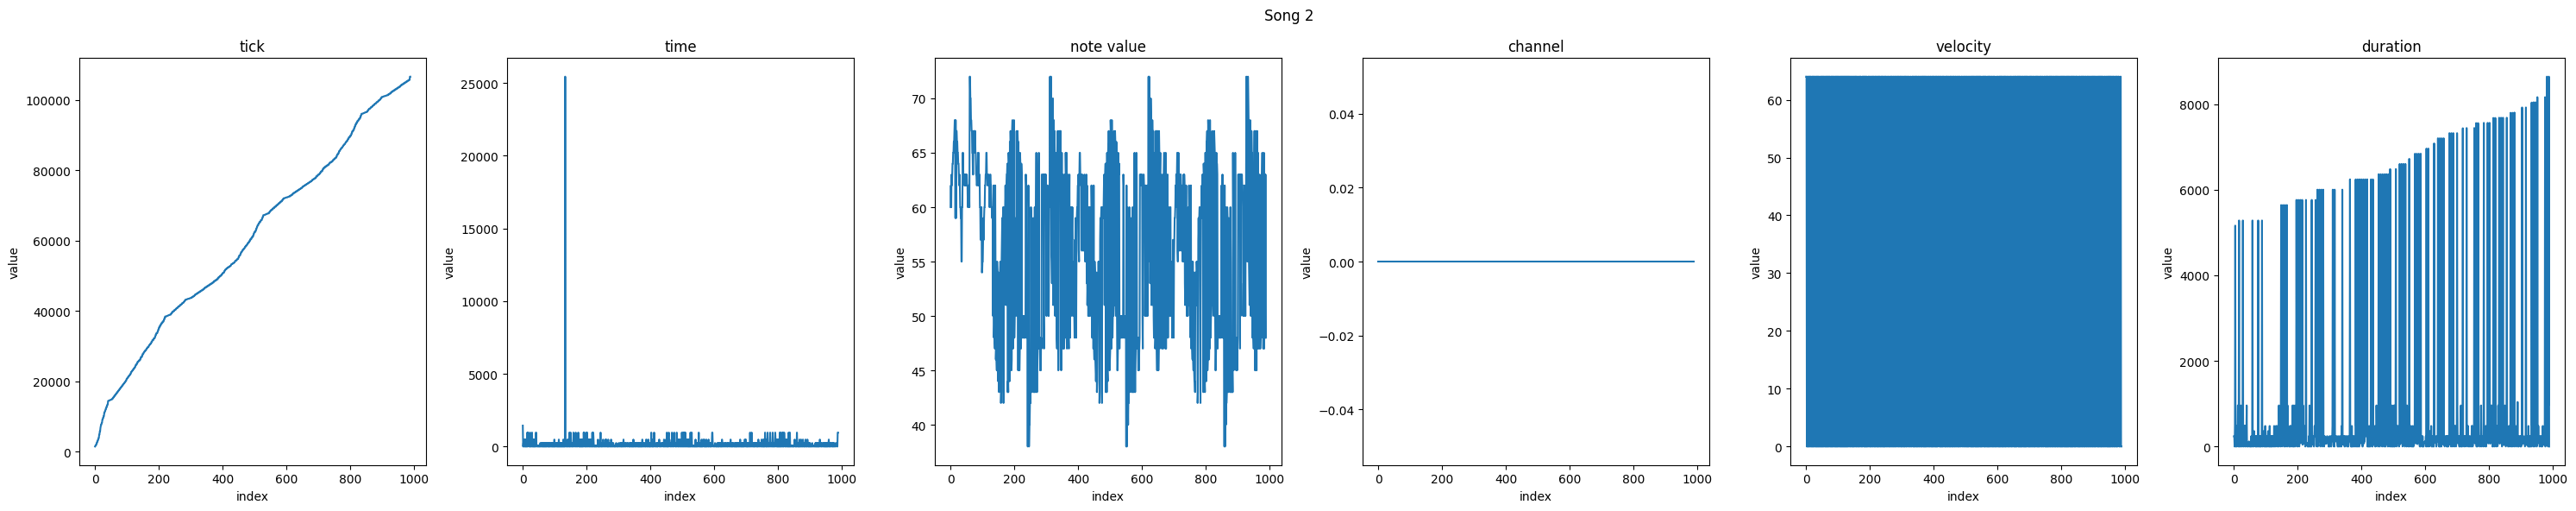

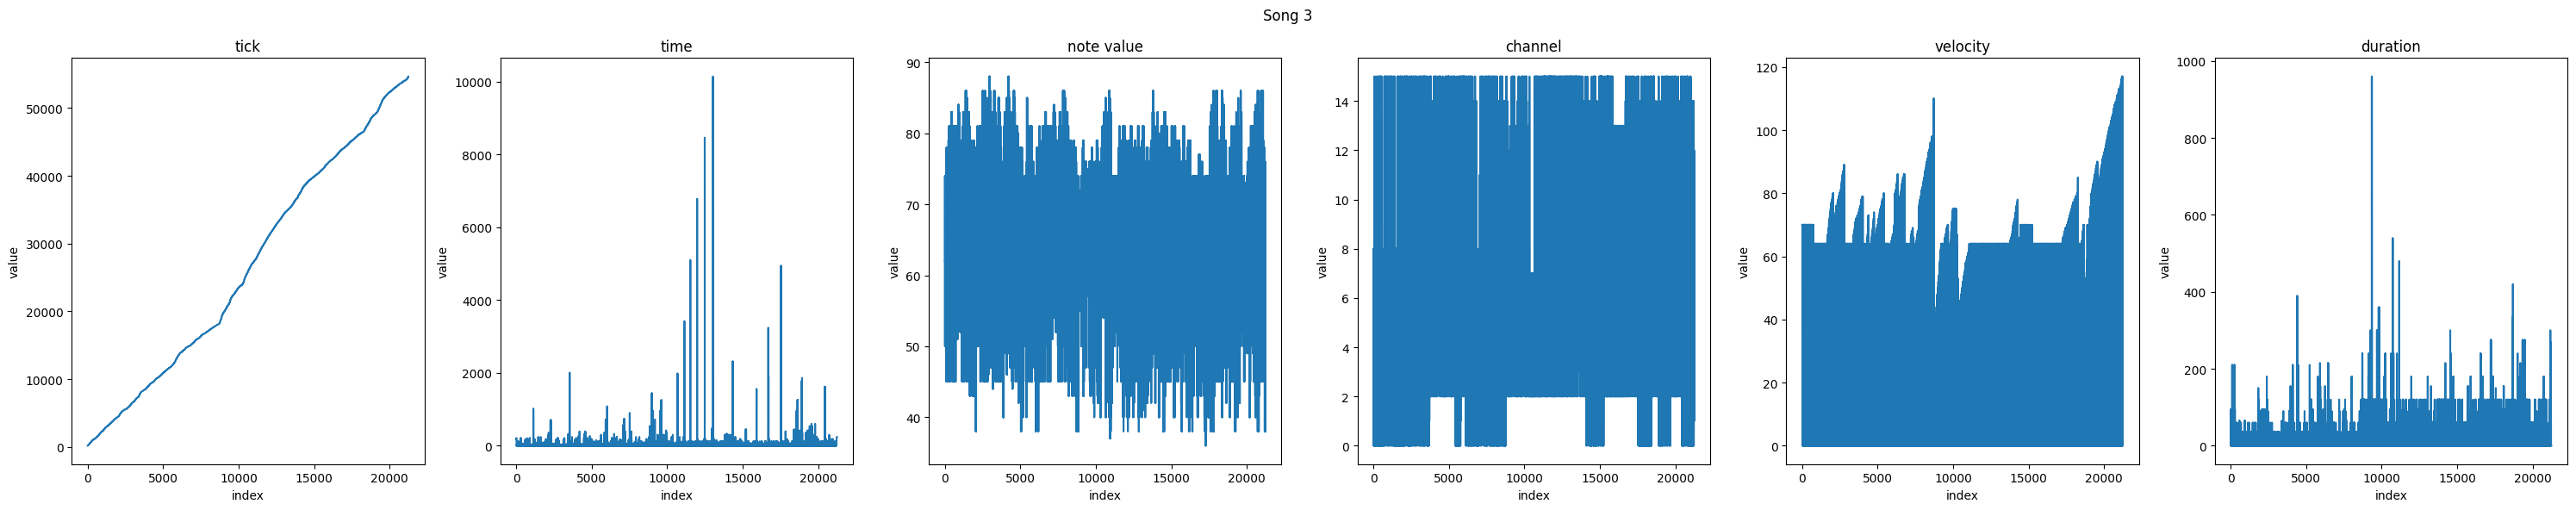

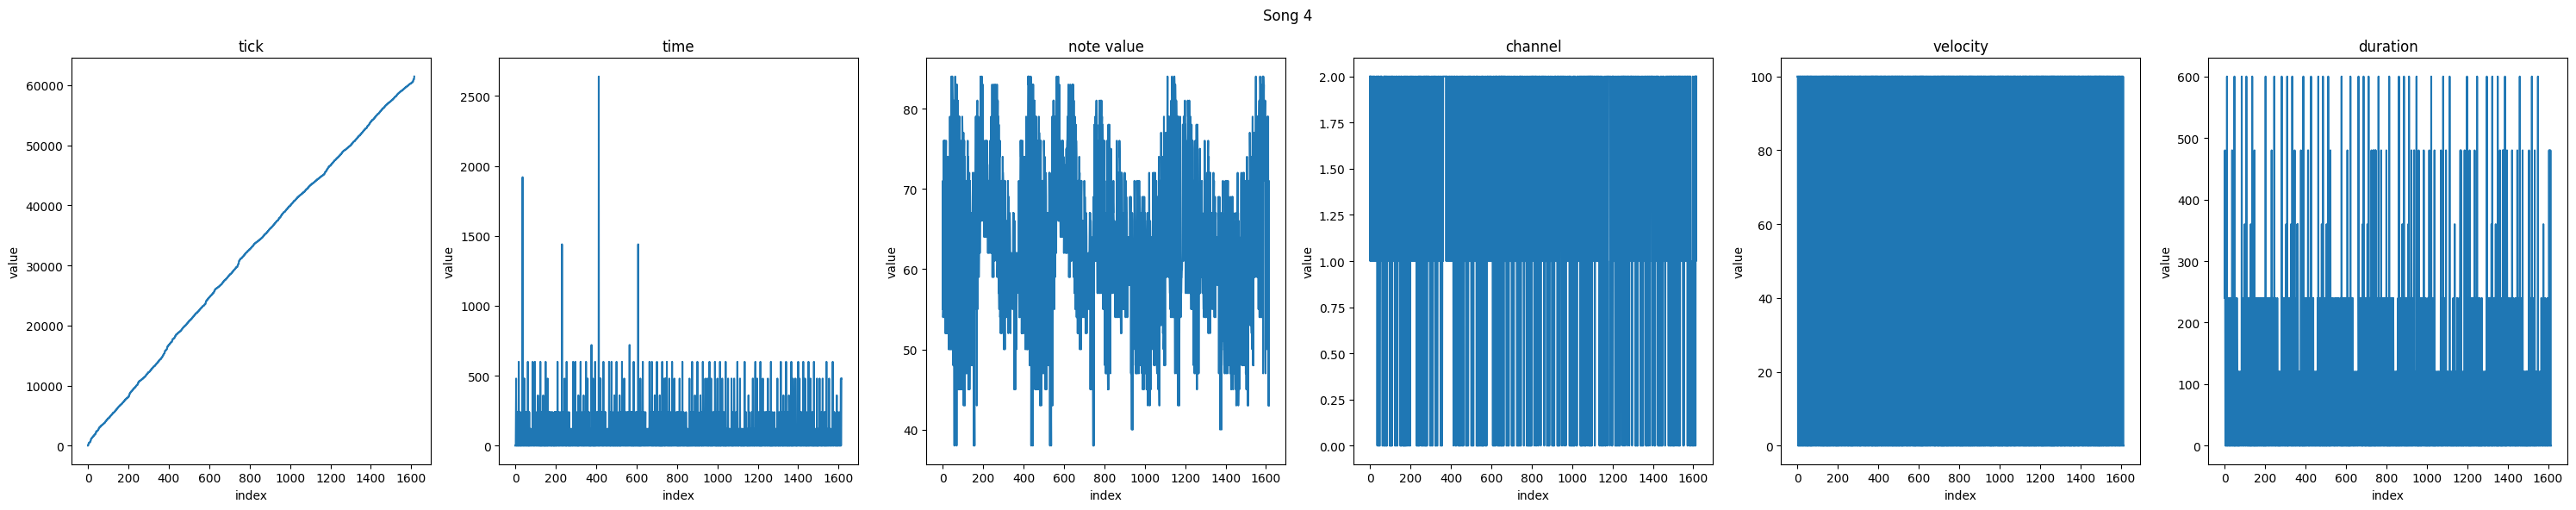

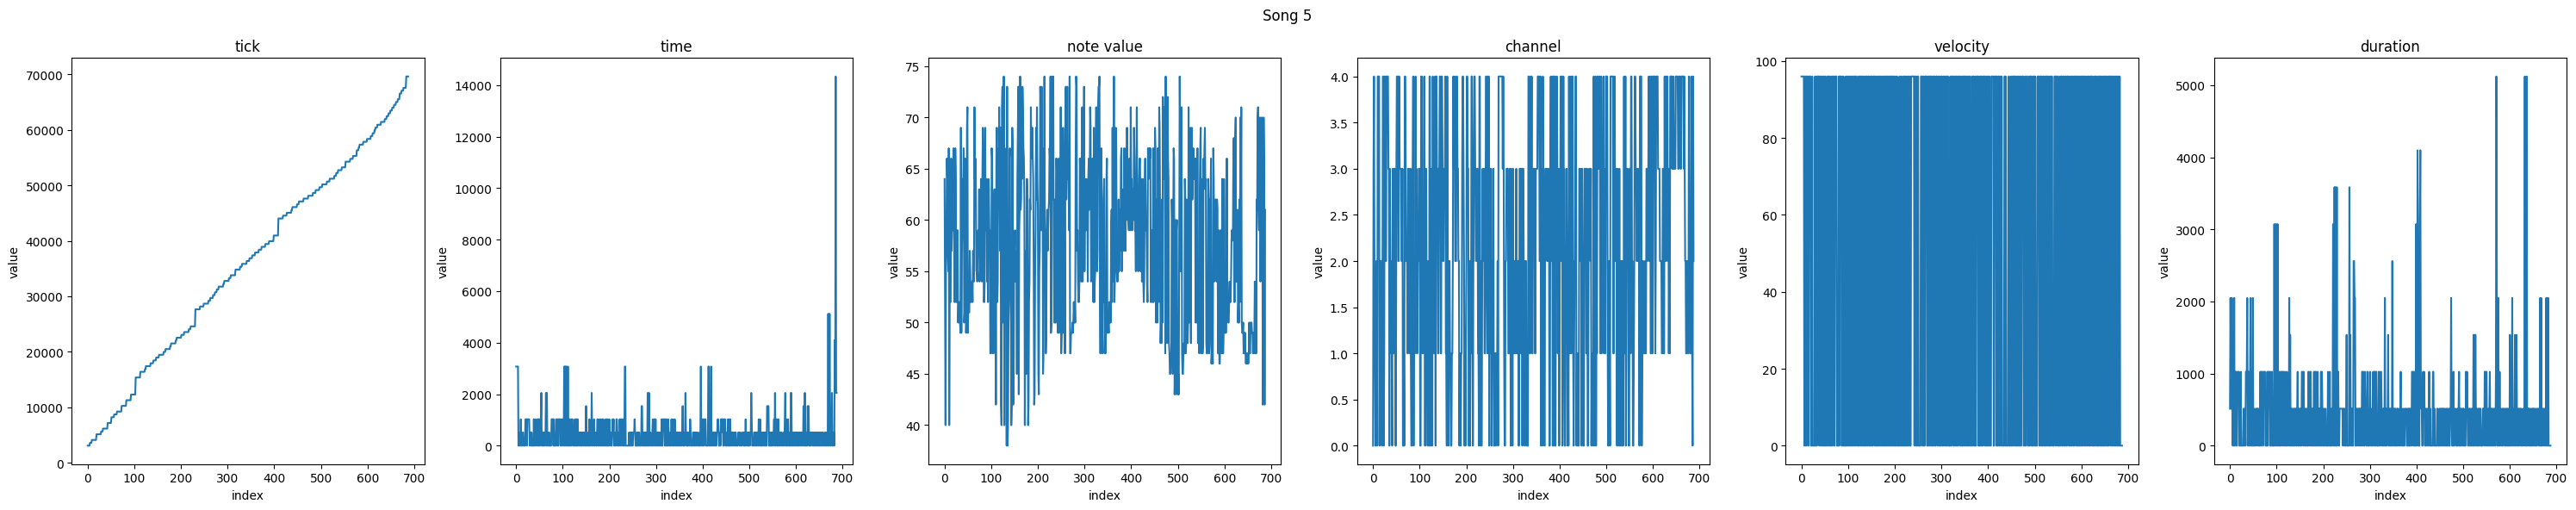

In [5]:
# TODO: actually find out what the channels are called, this is the substitute for now
channel_names = [f'channel {p}' for p in range(6)]
channel_names = ['tick','time','note value','channel','velocity','duration']

song_data = np.load('data/Bach.npy', allow_pickle=True)
# print all the channels for the first 5 of Bach's songs
for i in range(5):
    # grab the data. it is stored as an array of numpy arrays
    song = song_data[i]
    plt.figure(figsize=(30,6))
    # show the data for each of the channels for each song
    for p in range(6):
        plt.subplot(1,6,p+1)
        plt.plot(song[:,p])
        plt.title(channel_names[p])
        plt.xlabel('index')
        plt.ylabel('value')
    plt.suptitle(f'Song {i+1}')
    plt.tight_layout()
    plt.show()

The time series for the most part follow what we'd expect to see from the MIDI data. The only thing that blatantly unexplainable are the time plots. Many of them have large spikes at certain points, which, based on what we know, should correspond to large vertical jumps in the ticks plots. However, we are not seeing that relationship between the plots. These unexplainable jumps may be noise but we need to do checks for sure to see if the changes in the ticks are really accounted for in the time plots or if this is an error

# 4. 
How much data is missing? Is the distribution of missing data likely different from the distribution of non-missing data? How might you do a meaningful imputation (if needed)? Are there variables that should be dropped? Implement some initial solutions.

The question of whether or not we have missing data is complicated with MIDI data. Some features are sparsely populated with Nan's between values. However, in our investigation we have learned that these features only have values at the points that the feature value is changed and that the Nan's between those changes mean that the value is fixed at the last assignment until a different value is specified.

The most interpretable features for which this happens are the channels and the key. For example, the key may begin as D-flat and then has Nan's until changing to G-minor at tick 25000. We are not sure whether we can drop these columns yet. Some of them may be useful for creating new music but are not useful for classification. Others, however, we are confident in dropping entirely as demonstrated in the Data Cleaning section. Also, We have implemented the solution of feature engineering in order to get the duration that the notes where played in order to make that particular feature more meaningful

# 5.
Is there any hint that the data you have collected is differently distributed from the actual application of interest? If so, is there a strategy, such as reweighing samples, that might help?

We are specifically training on Classical music. If we decide to apply a classifier or forecasting technique to other types of music, it may not work out as expected. For immediate purposes, classical music is the topic of interest that we use. Should we choose to expand our horizons. Other features may become more important depending on the genre.

# 6.
Use a histogram or KDE to visualize the distribution of key variables. Consider log-scaling or other scaling of the axes. How should you think about outliers? Is there a natural scaling for certain variables? 

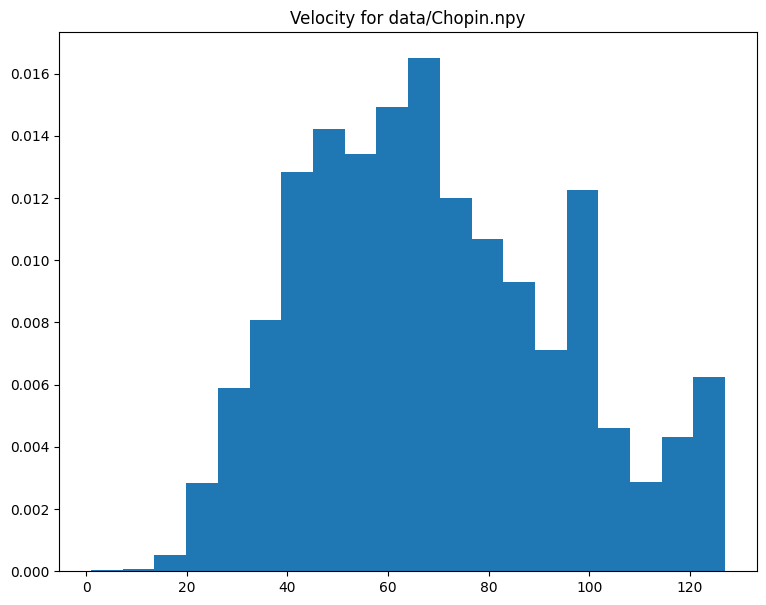

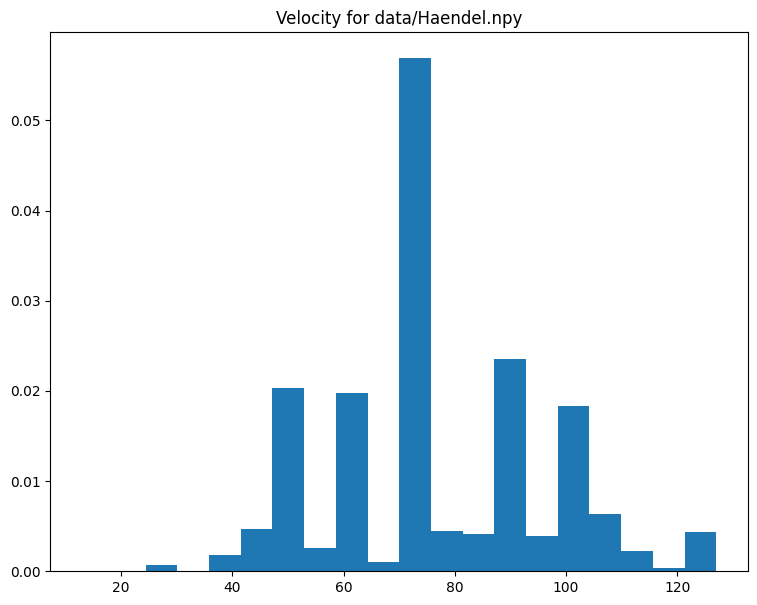

In [ ]:
#Compare Chopin to Handel for key variable velocity
dirs = ["data/Chopin.npy","data/Haendel.npy"]
for i,file in enumerate(dirs):
    song_data = np.load(file, allow_pickle=True)
    concat_data = np.empty((0,6))
    for song in song_data:
        concat_data = np.concatenate((concat_data,song))

    fig, ax = plt.subplots(figsize=(9,7))
    non_zero = concat_data[concat_data[:,4] != 0]
    ax.hist(non_zero[:,4],bins=20, density=True)
    ax.set_title("Velocity for " + file)
    uni = np.unique(concat_data[:,4])
    plt.show()

It does not look like we will have too many issues with the scaling for our variables. Our data is derived from midi files and in some sense, should be somewhat noiseless. Outliers in our data are thus, significant, and not due to random noise. It would not be appropriate for us to remove them.

The midi files are pretty nicely formatted so the default scaling for almost all of the variables should be appropriate.

# 7.
Use 2D and/or 3D plot scatter plots, histograms, or heat maps to look for important relationships between variables. Consider using significance tests, linear model fits, or correlation matrices to clarify relationships. 

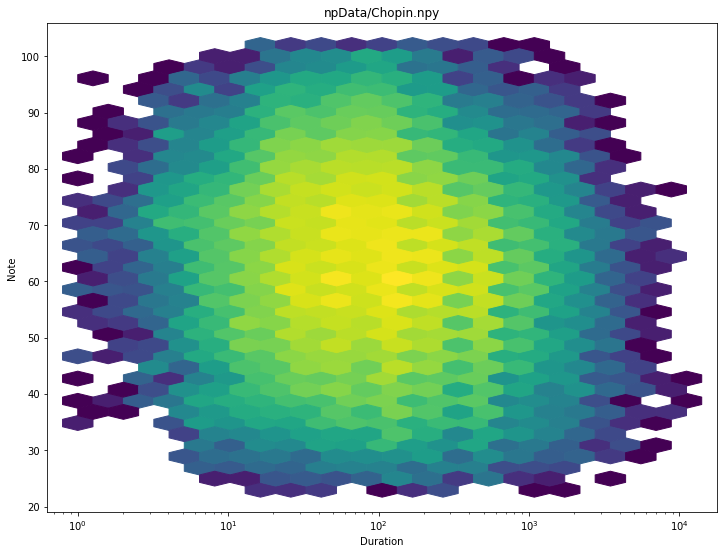

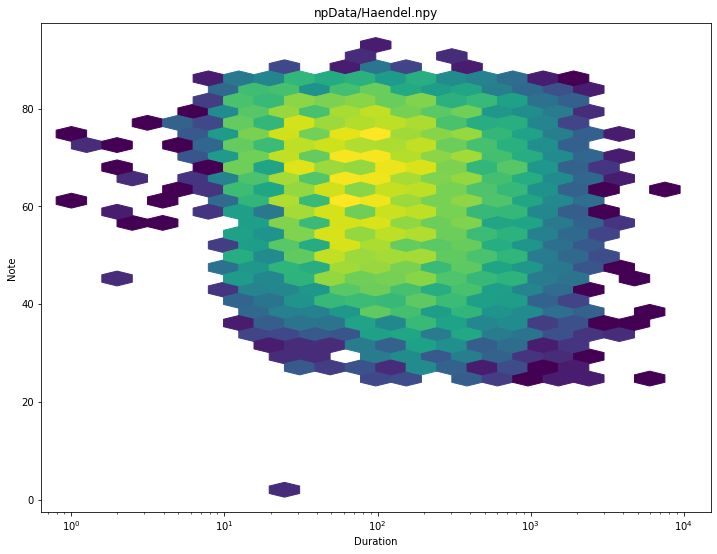

In [ ]:
#John's plots go here!
#Compare Chopin to Handel key variables Duration vs Note
dirs = ["npData/Chopin.npy","npData/Haendel.npy"]
for i,file in enumerate(dirs):
    song_data = np.load(file, allow_pickle=True)
    concat_data = np.empty((0,6))
    for song in song_data:
        concat_data = np.concatenate((concat_data,song))

    fig, ax = plt.subplots(figsize=(12,9))
    on_data = concat_data[concat_data[:,4] != 0]
    ax.hexbin(on_data[:,5],on_data[:,2],gridsize=(20,20),xscale='log',bins='log')
    ax.set_title(file)
    ax.set_xlabel("Duration")
    ax.set_ylabel("Note")
    plt.show()

These hexbins reveal some really cool features of our data. During Haendel's day, piano keyboards were actually shorter than they are today. Piano keyboards grew as classical composers felt the need to have more notes available to them. This is reflected in the visualizations we have made: the second plot (Haendel's work) has a much smaller range of notes than the first plot (Chopin's work).

# 8.
Does what you see change any of your ideas for what models might be appropriate? Among other things, if your models rely on specific assumptions, is there a way you can check if these assumptions actually hold by looking at the data? If you are using linear models, do the relevant plots look linear? Is there some other scaling where the model assumptions might more nearly hold?

After looking at the hexbin plots, we are very optimistic that we will be able to classify the composers and achieve our adequate goal. We thought that we might be able to use a logistic or softmax regression over the notes and duration, to be able to classify the piece. After learning about using the Kalman filter to forecast in class today, we feel that the Kalman filter will be a great model to use for predicting the next notes in the song.